In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Exercise 55

5.1 Classification: 1D case

This exercise is about learning to make classification with a neural network. 
To make things simple, it deals with a 1-dimensional descriptor space. 
I.e. every data is described by one coordinate, x. 
The data will be characterized by one of three labels: 0, 1, or 2.

5.2 Model predicting weights

a) Make a linear model that takes one input, and outputs 3 values


In [149]:
class LinModel(torch.nn.Module):
    def __init__(self, n_features=1, n_classes=3):
        """
        Initializes the LinModel.
        
        Args:
            n_features (int): The number of input features.
            n_classes (int): The number of output classes (or dimensions).
        """
        super().__init__()
        # Define a single linear layer (fc1)
        # Maps 'n_features' input features to 'n_classes' output logits
        self.fc1 = torch.nn.Linear(n_features, n_classes)
        
    def forward(self, x):
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, n_features).
        
        Returns:
            torch.Tensor: Output logits of shape (batch_size, n_classes).
        """
        # Pass the input through the linear layer
        return self.fc1(x)

In [150]:
# Instantiate the LinModel with 1 input feature and 3 output classes
model = LinModel(n_features=1, n_classes=3)

# Input tensor: A single sample with 1 feature (batch size of 1)
x = torch.tensor([[2.0]])

# Perform a forward pass through the model
y = model(x)

# Print the input and the output logits
print("Input:", x)  # Input to the model
print("Output:", y)  # Output logits for 3 classes

# Loop through the model's parameters (weights and biases)
for name, parameter in model.named_parameters():
    # Print the name of the parameter and its current values
    print(name, '=', parameter.data)


Input: tensor([[2.]])
Output: tensor([[0.9138, 1.1265, 1.9057]], grad_fn=<AddmmBackward0>)
fc1.weight = tensor([[0.3279],
        [0.3540],
        [0.9669]])
fc1.bias = tensor([ 0.2579,  0.4184, -0.0281])


b) Set the three weights in the model to 0.7, 0.25 and 0.9, respectively and the three biases to 1,−0.4, and 0.5

In [151]:
model = LinModel()
model.fc1.weight.data = torch.tensor([[0.7], [0.25], [0.9]]) 
model.fc1.bias.data = torch.tensor([1, -0.4, 0.5])

c) Check that the parameters are set correctly by obtaining them from the model and writing them out:

In [152]:
for name, parameters in model.named_parameters():
    print(name,parameters)

fc1.weight Parameter containing:
tensor([[0.7000],
        [0.2500],
        [0.9000]], requires_grad=True)
fc1.bias Parameter containing:
tensor([ 1.0000, -0.4000,  0.5000], requires_grad=True)


d) Setup a tensor, test_P, with seven 
x-values from 
−6 to 
6:



In [186]:
test_P = torch.arange(-6, 7, 2)
test_P = test_P.to(torch.float) # convert entries to float type
test_P = test_P.float().view(-1, 1) # reshapoe tensor to have correct dimensions
test_P

tensor([[-6.],
        [-4.],
        [-2.],
        [ 0.],
        [ 2.],
        [ 4.],
        [ 6.]])

e) Pass the tensor to the network and check that it predicts these weights:

In [154]:
predicted_weights = model(test_P)
predicted_weights

tensor([[-3.2000, -1.9000, -4.9000],
        [-1.8000, -1.4000, -3.1000],
        [-0.4000, -0.9000, -1.3000],
        [ 1.0000, -0.4000,  0.5000],
        [ 2.4000,  0.1000,  2.3000],
        [ 3.8000,  0.6000,  4.1000],
        [ 5.2000,  1.1000,  5.9000]], grad_fn=<AddmmBackward0>)

5.3 Softmax

f) Implement a function f_softmax according to:

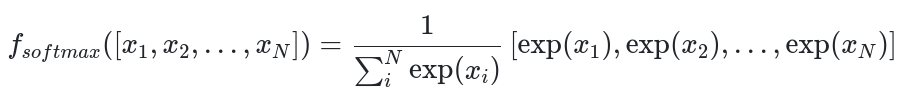

Hint: check that you get this output when applying your function to test_P:

In [155]:
def f(x):
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1, keepdim=True)

# Compute softmax
predicted_probabilities = f(predicted_weights)
predicted_probabilities


tensor([[0.2061, 0.7562, 0.0377],
        [0.3617, 0.5397, 0.0986],
        [0.4967, 0.3013, 0.2020],
        [0.5396, 0.1331, 0.3273],
        [0.4987, 0.0500, 0.4513],
        [0.4183, 0.0171, 0.5646],
        [0.3300, 0.0055, 0.6645]], grad_fn=<DivBackward0>)

Note how the numbers in each row sum up to 1. They can thus be interpreted as probabilities for getting each of the three labels (e.g. 0, 1, or 2) for the independent variable, 
x_ 
i
​
 , corresponding to the 
i'th row.

g) Check that with the PyTorch-function torch.softmax you get the same probabilities:

In [156]:
dim = 1

pytorch_softmax = torch.softmax(predicted_weights,dim,dtype=None)
pytorch_softmax

if np.allclose(predicted_probabilities.detach().numpy(), pytorch_softmax.detach().numpy(), rtol=1e-05, atol=1e-08, equal_nan=False):
    print("The two tensors are equal, i.e. the softmax functions are the same!")


The two tensors are equal, i.e. the softmax functions are the same!


5.4 Cross-entropy

Our network is not trained yet, and its weights that we just turned into probabilities using softmax are basically just random. Nonetheless, call the probability distribution that the network codes for: 
Q. Later in this exercise, we will have some observations, that stem from another distribution, 
P, and minimizing the cross-entropy, 
H(P,Q), by optimizing the model parameters will lead to the neural network model learning to provide weights that code for 
P. However, we start by asking the question:

What are, according to 
Q, the most likely observations for 
x
∈
{
x
1
,
x
2
,
…
,
x
N
} ?

To answer that, consider the cross-entropy between the two distributions which is given by:

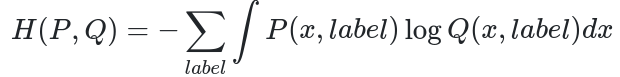

where 
x is the independent variable, and 
l
a
b
e
l
label runs over the three possible values (e.g. 0, 1, and 2).

Our knowledge about the distribution P comes via N observations: {(x1,label_1),(x2,label_2),...,(x_N,label_N)}, where for now we ask what the most likely labels are? With P known via observations, the cross-entropy is given by:

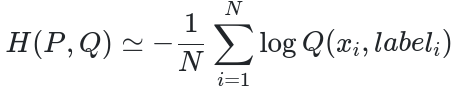

h) Minimize H(P,Q) with respect o {label1, label2,...label_N} for [x1,x2,...x_N]=test_P.

Hint 1: Write a code like this:

Loop a finite number of times

- guess N random labels

- evaluate the cross-entropy with those N guessed observations

- print out the value of the cross-entropy and the guessed observations if they give the smallest cross-entropy seen so far.

Hint 2: Complete this function for evaluating the cross-entropy:

In [157]:
def cross_entropy_from_probabilities(probabilities, guessed_labels):
    # Gather the probabilities corresponding to the guessed labels
    probabilities_for_guessed_labels = torch.gather(probabilities,
                                                    dim=1,
                                                    index=guessed_labels.unsqueeze(1))
    return -torch.mean(torch.log(probabilities_for_guessed_labels))

In [173]:
import random

# Convert logits to probabilities using softmax
Q = torch.softmax(predicted_weights, dim=1)

# Number of samples (N) and classes (C)
N, C = Q.shape

# Function to compute cross-entropy
def compute_cross_entropy(probabilities, guessed_labels):
    probabilities_for_guessed_labels = torch.gather(probabilities, dim=1, index=guessed_labels.unsqueeze(1))
    return -torch.mean(torch.log(probabilities_for_guessed_labels))

# Initialize the smallest cross-entropy and best labels
smallest_cross_entropy = float('inf')
best_labels = None

# Loop a finite number of times
for _ in range(100):  # Number of random guesses
    # Generate N random labels (one for each sample)
    guessed_labels = torch.tensor([random.randint(0, C - 1) for _ in range(N)])

    # Evaluate cross-entropy for the guessed labels
    cross_entropy = compute_cross_entropy(Q, guessed_labels)

    # Update the smallest cross-entropy and best labels
    if cross_entropy < smallest_cross_entropy:
        smallest_cross_entropy = cross_entropy
        best_labels = guessed_labels

        # Print the current smallest cross-entropy and corresponding labels
        print(f"{smallest_cross_entropy.item()} {best_labels}")


1.869808554649353 tensor([0, 2, 2, 2, 0, 2, 1])
1.1840944290161133 tensor([0, 1, 1, 0, 1, 0, 2])
0.9840943217277527 tensor([0, 1, 2, 0, 2, 2, 0])
0.741237223148346 tensor([1, 0, 2, 0, 0, 2, 2])
0.5698086619377136 tensor([1, 1, 0, 0, 2, 2, 2])


i) Now that you have implemented cross-entropy yourself, it is time to use the cross-entropy function implemented in PyTorch. For reasons of efficiency, the PyTorch class implementing cross-entropy in PyTorch takes the raw output weights of the neural network as input (i.e. not the probabilities after applying the softmax). Hint: Complete this code:

In [174]:
criterion = torch.nn.CrossEntropyLoss()
criterion(predicted_weights, torch.tensor([1, 1, 0, 0, 0, 2, 2], dtype=torch.long))

tensor(0.5555, grad_fn=<NllLossBackward0>)

5.5 Model predictions of label

In the last question, you varied the possibly observed labels in order to minimize the cross-entropy for a fixed model. This led to the most likely observed labels. But honestly, those labels can be obtained in a much easier way: You can simply find the label with the largest predicted probability for each input, 
x_i.

j) Extend the model with a method to predict the labels.

(Use argmax)

In [175]:
# Define the predict_label function
def predict_label(self, x):
    # Perform a forward pass to get logits
    logits = self.forward(x)
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(logits, dim=1)
    # Use argmax to find the index of the highest probability
    predicted_labels = torch.argmax(probabilities, dim=1)
    return predicted_labels

setattr(LinModel, "predict_label", predict_label) # attaching the new function to the LinModel class

k) Check that you get the same labels as in the cross-entropy optimization:

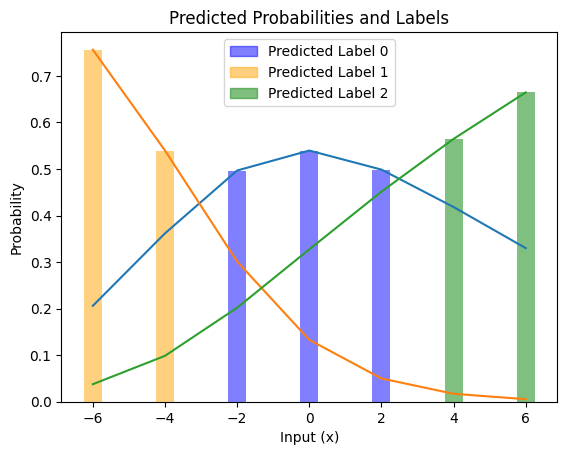

In [187]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Get logits and probabilities from the model
logits = model(test_P)
probabilities = torch.softmax(logits, dim=1)  # Compute probabilities
predicted_labels = model.predict_label(test_P)  # Predicted labels

# Convert tensors to NumPy arrays for plotting
x = test_P.numpy().flatten()  # Inputs (x-axis values)
probabilities_np = probabilities.detach().numpy()  # Probabilities
predicted_labels_np = predicted_labels.numpy()  # Predicted labels

# Plot probability curves for each class
for class_idx in range(probabilities_np.shape[1]):
    plt.plot(x, probabilities_np[:, class_idx], label=f"Q_init(x, {class_idx})")

# Add bars for probabilities of predicted labels
colors = ['blue', 'orange', 'green']  # Colors for the classes
for i, x_val in enumerate(x):
    # Get the predicted label and its probability
    predicted_label = predicted_labels_np[i]
    probability = probabilities_np[i, predicted_label]
    # Plot a bar with the corresponding class color
    plt.bar(x_val, probability, width=0.5, alpha=0.5, color=colors[predicted_label])

# Add legend entries for bars
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.5, label=f"Predicted Label {class_idx}")
    for class_idx, color in enumerate(colors)
]
plt.legend(handles=handles)

# Add labels and title
plt.xlabel("Input (x)")
plt.ylabel("Probability")
plt.title("Predicted Probabilities and Labels")
plt.show()


and plot them (the heights of the bars are not so important):

Include in the plot three curves, 
Q_init(x,label), for the probabilities of the three different labels as predicted by the yet untrained neural network.

5.6 Optimize model
You have now worked with all the ingredients required to train a network for classification: weight-prediction, conversion to probabilities with softmax, and probability comparisons via cross-entropy. Now is time for introducing some data that will represent the probability distribution 
P
(
x
,
l
a
b
e
l
)
P(x,label).

l) Compose the data in this way:

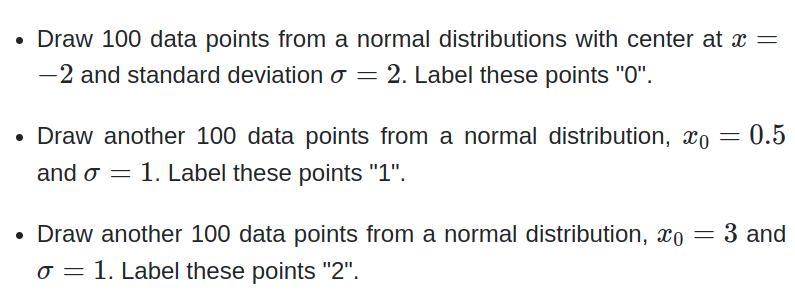

In [207]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate 100 data points from the first normal distribution (label 0)
# Center on x0=0 and standard deviation = 2
x0 = np.random.normal(loc=-2, scale=2, size=100)

# Generate 100 data points from the second normal distribution (label 1)
# Center on x0=0.5 and standard deviation = 1
x1 = np.random.normal(loc=0.5, scale=1, size=100)

# Generate 100 data points from the third normal distribution (label 2)
# Center on x0=3 and standard deviation = 1
x2 = np.random.normal(loc=3, scale=1, size=100)

# Combine the data and labels
x = np.concatenate([x0, x1, x2])  # Combine all data points

# Shuffle the data and labels together
indices = np.random.permutation(len(x))
x = x[indices]

print(x0)


[-1.00657169e+00 -2.27652860e+00 -7.04622924e-01  1.04605971e+00
 -2.46830675e+00 -2.46827391e+00  1.15842563e+00 -4.65130542e-01
 -2.93894877e+00 -9.14879913e-01 -2.92683539e+00 -2.93145951e+00
 -1.51607546e+00 -5.82656049e+00 -5.44983567e+00 -3.12457506e+00
 -4.02566224e+00 -1.37150533e+00 -3.81604815e+00 -4.82460740e+00
  9.31297538e-01 -2.45155260e+00 -1.86494359e+00 -4.84949637e+00
 -3.08876545e+00 -1.77815482e+00 -4.30198715e+00 -1.24860396e+00
 -3.20127738e+00 -2.58338750e+00 -3.20341322e+00  1.70455637e+00
 -2.02699445e+00 -4.11542186e+00 -3.54910176e-01 -4.44168730e+00
 -1.58227281e+00 -5.91934025e+00 -4.65637210e+00 -1.60627753e+00
 -5.23066840e-01 -1.65726344e+00 -2.23129656e+00 -2.60220739e+00
 -4.95704398e+00 -3.43968842e+00 -2.92127754e+00  1.14244452e-01
 -1.31276342e+00 -5.52608031e+00 -1.35183206e+00 -2.77016456e+00
 -3.35384400e+00 -7.76647422e-01  6.19990450e-02 -1.37439762e-01
 -3.67843505e+00 -2.61842475e+00 -1.33747314e+00 -4.89097458e-02
 -2.95834848e+00 -2.37131

and plot it:

<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_118896/594593619.py:35: SyntaxWarning: invalid escape sequence '\m'
  label=f"$P(x, \mathrm{{label}}={label})$"
/tmp/ipykernel_118896/594593619.py:41: SyntaxWarning: invalid escape sequence '\m'
  plt.title("Probability Distribution $P(x, \mathrm{label})$")


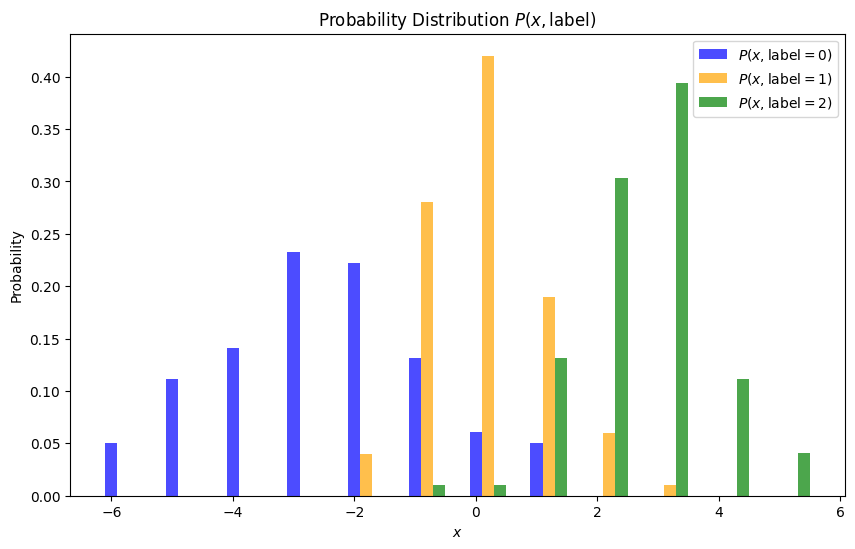

In [208]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate the data
x_0 = np.random.normal(loc=-2, scale=2, size=100)
x_1 = np.random.normal(loc=0.5, scale=1, size=100)
x_2 = np.random.normal(loc=3, scale=1, size=100)

# Combine data and corresponding labels
x = np.concatenate([x_0, x_1, x_2])
labels = np.concatenate([np.zeros(100), np.ones(100), np.full(100, 2)])

# Plot the histogram-like bar chart
bins = np.linspace(-6, 6, 13)  # Define bins for the histogram
colors = ['blue', 'orange', 'green']

# Create the bar chart
plt.figure(figsize=(10, 6))
for label, color in enumerate(colors):
    # Filter data by label
    data = x[labels == label]
    # Compute histogram values
    hist, bin_edges = np.histogram(data, bins=bins, density=True)
    # Plot bars for each class
    plt.bar(
        bin_edges[:-1] + label * 0.2,  # Offset bars slightly for each class
        hist,
        width=0.2,
        color=color,
        align='center',
        alpha=0.7,
        label=f"$P(x, \mathrm{{label}}={label})$"
    )

# Add labels and legend
plt.xlabel("$x$")
plt.ylabel("Probability")
plt.title("Probability Distribution $P(x, \mathrm{label})$")
plt.legend()
plt.show()


m) Predict and plot the labels for the training data with the untrained neural network:

Notice how wrong the initial, untrained network is in predicting the labels.

n) Use the cross-entropy as a loss-function in the optimization of the parameters of the neural network behind the probability density 
Q. Plot both the 
Q
(
x
,
l
a
b
e
l
) curves of the trained network and insert the label-predictions for all 
x-values in the training set.

In [163]:
for epoch in range(n_epochs):
    optimizer.zero_grad()
    ... = model( ...
    loss = ...
    loss.backward()
    optimizer.step()

SyntaxError: '(' was never closed (953069956.py, line 3)

o) Plot the two probabilities, 
P and Q, as you know them best. I.e. plot the data points for P that were used for the training, and plot the three probability curves, one for each label, according to the trained neural network, i.e. Q(x,label):

Exercise 56

6.1 Classification: 2D case

a) Make a dataset, {((x_{1,i},x_{2,i}),label_i)}, where the (x_{1,i},x_{2,i}) points are normally distributed (with standard deviation 2) around (-2,3), (0.5,-3), and (3,1), respectively.

blue
orange
green


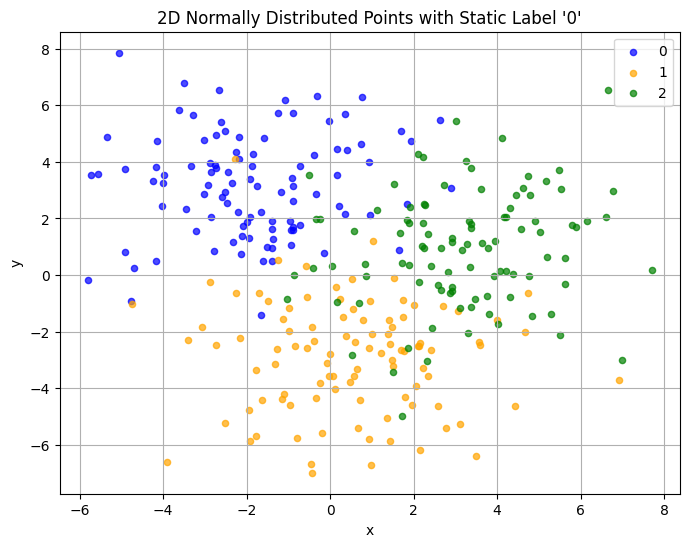

[([ 2.6277745e+00,  5.4664860e+00], 'blue')
 ([-2.6249826e+00,  5.3966007e+00], 'blue')
 ([-9.5706928e-01,  1.8962479e+00], 'blue')
 ([-1.9902375e+00,  1.8757648e+00], 'blue')
 ([-4.1573038e+00,  4.7474775e+00], 'blue')
 ([-3.3348873e-01,  2.8708441e+00], 'blue')
 ([-2.5286245e+00,  2.9315948e+00], 'blue')
 ([-9.4856042e-01,  1.6101744e+00], 'blue')
 ([-3.6102641e+00,  5.8188534e+00], 'blue')
 ([-2.5196331e+00,  5.0809851e+00], 'blue')
 ([-2.5888989e+00,  2.7620375e+00], 'blue')
 ([-8.9877009e-01,  1.7092139e+00], 'blue')
 ([-1.3843124e+00,  1.6206765e+00], 'blue')
 ([-2.3531873e+00,  3.2664766e+00], 'blue')
 ([-2.7398884e+00,  3.7735398e+00], 'blue')
 ([-1.3701798e+00,  1.2751566e+00], 'blue')
 ([-1.6045692e+00,  5.1025689e-01], 'blue')
 ([-1.7421534e+00,  3.1593084e+00], 'blue')
 ([ 1.9386806e+00,  4.7293258e+00], 'blue')
 ([-8.9612734e-01,  3.1476653e+00], 'blue')
 ([ 1.8480670e+00,  2.5012643e+00], 'blue')
 ([-2.1390119e+00,  7.3999923e-01], 'blue')
 ([-2.0968266e+00,  1.7320241e+0

In [257]:
# Standard deviation
std = 2  # Standard deviation

# Number of points to generate
n_points = 100

# Define the structured dtype
dtype = [('coords', '2f4'),  # Two floats (float32)
         ('label', 'U10')]  # A string of max length 10

# Start with an empty structured array
points = np.empty(0, dtype=dtype)

# Colors (not tied to the labels in this case)
colors = ('blue', 'orange', 'green')
labels = ["0","1","2"]

# Plot the points
plt.figure(figsize=(8, 6))

x0s = [(-2,3),(0.5,-3),(3,1)]

for i in range(len(colors)):
    color = colors[i]
    # Center of the distribution
    center_x, center_y = x0s[i][0],x0s[i][1]  # Mean (center) of the distribution
    # Generate the points
    x_points = np.random.normal(loc=center_x, scale=std, size=n_points)
    y_points = np.random.normal(loc=center_y, scale=std, size=n_points)

    # Combine into a structured dataset with static label "0"
    new_points = np.array(
        [((x, y), color) for x, y in zip(x_points, y_points)],
        dtype=dtype
    )

    # Concatenate with the existing points
    points = np.concatenate((points, new_points))

    plt.scatter(
        new_points['coords'][:, 0],
        new_points['coords'][:, 1],
        alpha=0.7,
        label=labels[i],
        color=color,
        s=20
    )
    print(color)

plt.title("2D Normally Distributed Points with Static Label '0'")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

print(points)

b) Make a one-layer feedforward linear NN with two inputs and three outputs. Train the network using a cross-entropy loss function.

In [276]:
blue_points = points[0:99]
orange_points = points[100:199]
green_points = points[200:299]
blue_coords = [point[0] for point in blue_points]
orange_coords = [point[0] for point in orange_points]
green_coords = [point[0] for point in green_points]

# Combine the coordinates into a single tensor
X = torch.tensor(blue_coords + orange_coords + green_coords, dtype=torch.float32)
print(len(blue_points))
print(len(X))
zeros = torch.zeros(99, dtype=torch.long)
ones = torch.ones(99, dtype=torch.long)
twos = torch.full((99,), 2, dtype=torch.long)
y  = torch.cat([zeros, ones, twos])

# Define the model
class OneLayerNN(nn.Module):
    def __init__(self):
        super(OneLayerNN, self).__init__()
        self.fc = nn.Linear(2, 3)  # Linear layer: 2 inputs, 3 outputs

    def forward(self, x):
        return self.fc(x)

# Initialize the model, loss function, and optimizer
model = OneLayerNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss for every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.no_grad():
    test_outputs = model(X)
    _, predicted = torch.max(test_outputs, 1)
    print("Predicted classes:", predicted.numpy())
    print("True classes:", y.numpy())


99
297
Epoch [10/1000], Loss: 0.4933
Epoch [20/1000], Loss: 0.4143
Epoch [30/1000], Loss: 0.3885
Epoch [40/1000], Loss: 0.3755
Epoch [50/1000], Loss: 0.3676
Epoch [60/1000], Loss: 0.3622
Epoch [70/1000], Loss: 0.3582
Epoch [80/1000], Loss: 0.3551
Epoch [90/1000], Loss: 0.3526
Epoch [100/1000], Loss: 0.3505
Epoch [110/1000], Loss: 0.3487
Epoch [120/1000], Loss: 0.3471
Epoch [130/1000], Loss: 0.3457
Epoch [140/1000], Loss: 0.3445
Epoch [150/1000], Loss: 0.3434
Epoch [160/1000], Loss: 0.3424
Epoch [170/1000], Loss: 0.3415
Epoch [180/1000], Loss: 0.3406
Epoch [190/1000], Loss: 0.3398
Epoch [200/1000], Loss: 0.3391
Epoch [210/1000], Loss: 0.3385
Epoch [220/1000], Loss: 0.3379
Epoch [230/1000], Loss: 0.3373
Epoch [240/1000], Loss: 0.3368
Epoch [250/1000], Loss: 0.3363
Epoch [260/1000], Loss: 0.3359
Epoch [270/1000], Loss: 0.3355
Epoch [280/1000], Loss: 0.3351
Epoch [290/1000], Loss: 0.3348
Epoch [300/1000], Loss: 0.3345
Epoch [310/1000], Loss: 0.3342
Epoch [320/1000], Loss: 0.3339
Epoch [330

c) Introduce that the network can predict the class for an input (x1,x2) as the label of maximum probability.

In [280]:
new_point = torch.tensor([[-0.5, 0.8]], dtype=torch.float32)

# Run the prediction
with torch.no_grad():
    logits = model(new_point)
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

print(f"Predicted class: {predicted_class.item()}")


Predicted class: 0


Plot the labels that are predicted for the {(x_{1,i},x_{2,i})}-points in the dataset.

Exercise 57

7.1 Classification of clusters

This exercise is about establishing a neural network that is capable of classifying 12-atomic Lennard-Jones_Gauss clusters based on a four-dimensional descriptor derived from the cluster coordinates. I.e the network will not require that the elaborate calculation of all interatomic distances is done. 

To train and test the neural network use provided file labeled_clusters_1000.txt. It contains positions, energies and labels for the clusters. 

The transformed positions and the raw labels will be used for the training and the testing, while the energies are included merely for plotting purposes.

7.2 Load the data

a) Load positions, energies and labels for 1000 LJG-clusters in 2D in this way: 

In [4]:
data_flat = np.loadtxt('labeled_clusters_1000.txt')
positions_from_file = data_flat[:,:24].reshape(-1,12,2)
energies_from_file = data_flat[:,24:25].reshape(-1)
labels_from_file = data_flat[:,-1:].reshape(-1).astype('int')

The first cluster is represented like this:

In [41]:
positions_from_file[:1],energies_from_file[:1],labels_from_file[:1]


(array([[[4.721805, 4.275757],
         [4.99196 , 2.669204],
         [4.631578, 5.889142],
         ...,
         [6.353148, 3.567599],
         [4.010138, 6.635914],
         [3.676022, 5.698195]],
 
        [[2.680719, 4.124725],
         [2.354589, 5.719567],
         [5.871461, 5.713344],
         ...,
         [5.539722, 4.792045],
         [4.573045, 4.613544],
         [5.217111, 3.86702 ]],
 
        [[5.860762, 4.761018],
         [6.62717 , 4.128806],
         [3.355774, 4.035401],
         ...,
         [4.15178 , 4.601712],
         [4.965719, 5.139432],
         [4.0538  , 6.570343]],
 
        ...,
 
        [[3.758938, 5.605325],
         [4.516245, 4.079972],
         [5.935391, 3.038748],
         ...,
         [7.327244, 6.104257],
         [6.347974, 5.926143],
         [4.648929, 6.059889]],
 
        [[6.557475, 6.000717],
         [7.203039, 5.259535],
         [5.297437, 4.860665],
         ...,
         [6.902911, 4.310567],
         [5.530332, 7.401684],
    

b) Plot a histogram for all clusters labeled 0, binned according to energy in 1-energy unit intervals. Repeat with new colors for clusters labelled 1 through 9.

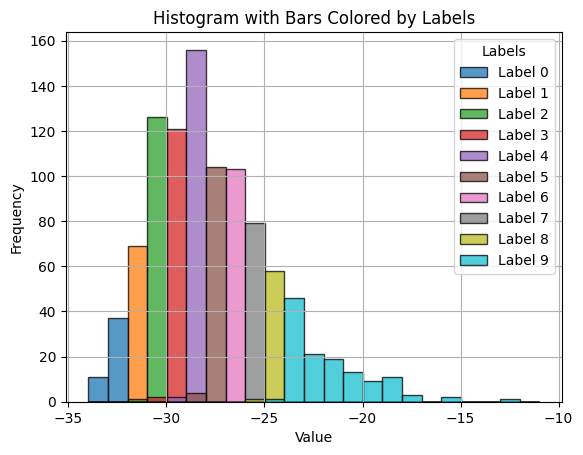

In [42]:
data = energies_from_file
labels = labels_from_file
colors = plt.cm.tab10(range(10))  # Use a colormap with 10 distinct colors

# Calculate bins with size 1
min_value = np.min(data)
max_value = np.max(data)
bins = np.arange(min_value, max_value + 2, 1)  # Bin edges with step size of 1

hist, bin_edges = np.histogram(data, bins=bins)

# Plot each group with a unique color
for label, color in enumerate(colors):
    group_data = data[labels == label]  # Select data for this label
    plt.hist(
        group_data, bins=bins, alpha=0.75, label=f'Label {label}', color=color, edgecolor='black'
    )

# Add labels, legend, and grid
plt.title('Histogram with Bars Colored by Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(title='Labels')
plt.grid(True)

# Show the plot
plt.show()

7.3 Descriptors

For each cluster, evaluate the center of mass:

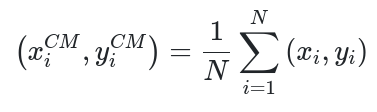

by using this method:

In [56]:
def center_of_mass(cluster):
    x_CM, y_CM = cluster.mean(axis=0)
    return x_CM, y_CM

# print(positions_from_file[:1][0][0])
# print(positions_from_file[:1][0][0].mean(axis=0))


Use this to calculate the 2nd, 4th, 6th, and 8th moments of the clusters with respect to their center of mass:

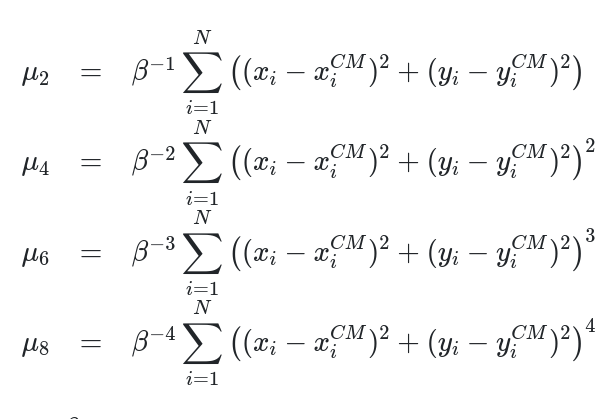

where the prefactors with β=3 are just data set-specific constants making the μ_i's have similar values.

In [71]:
def moment_calculator(cluster):

    # Number of points
    N = len(cluster)

    # Calculate the center of mass (x_CM, y_CM)
    x_CM, y_CM = cluster.mean(axis=0)

    # Compute squared distances from the center of mass
    distances_squared = (cluster[:, 0] - x_CM)**2 + (cluster[:, 1] - y_CM)**2

    beta = 3.0

    # Compute moments
    mu_2 = beta**-1 * np.sum(distances_squared)
    mu_4 = beta**-2 * np.sum(distances_squared**2)
    mu_6 = beta**-3 * np.sum(distances_squared**3)
    mu_8 = beta**-4 * np.sum(distances_squared**4)

    return mu_2, mu_4, mu_6, mu_8

Trying out an example calculation of moments for one cluster

In [72]:
some_cluster = positions_from_file[:1][0]
print(some_cluster)
print(moment_calculator(some_cluster))

[[4.721805 4.275757]
 [4.99196  2.669204]
 [4.631578 5.889142]
 [4.373125 7.554287]
 [5.004835 6.797513]
 [5.602687 6.016059]
 [6.18045  5.206921]
 [5.71127  4.300034]
 [5.206776 5.119051]
 [6.353148 3.567599]
 [4.010138 6.635914]
 [3.676022 5.698195]]
(np.float64(9.865364025106556), np.float64(13.829021373512344), np.float64(24.50190923966871), np.float64(48.178460744003345))


c) Plot some of the structures and indicate their energies and labels in the titles, along with their moments.

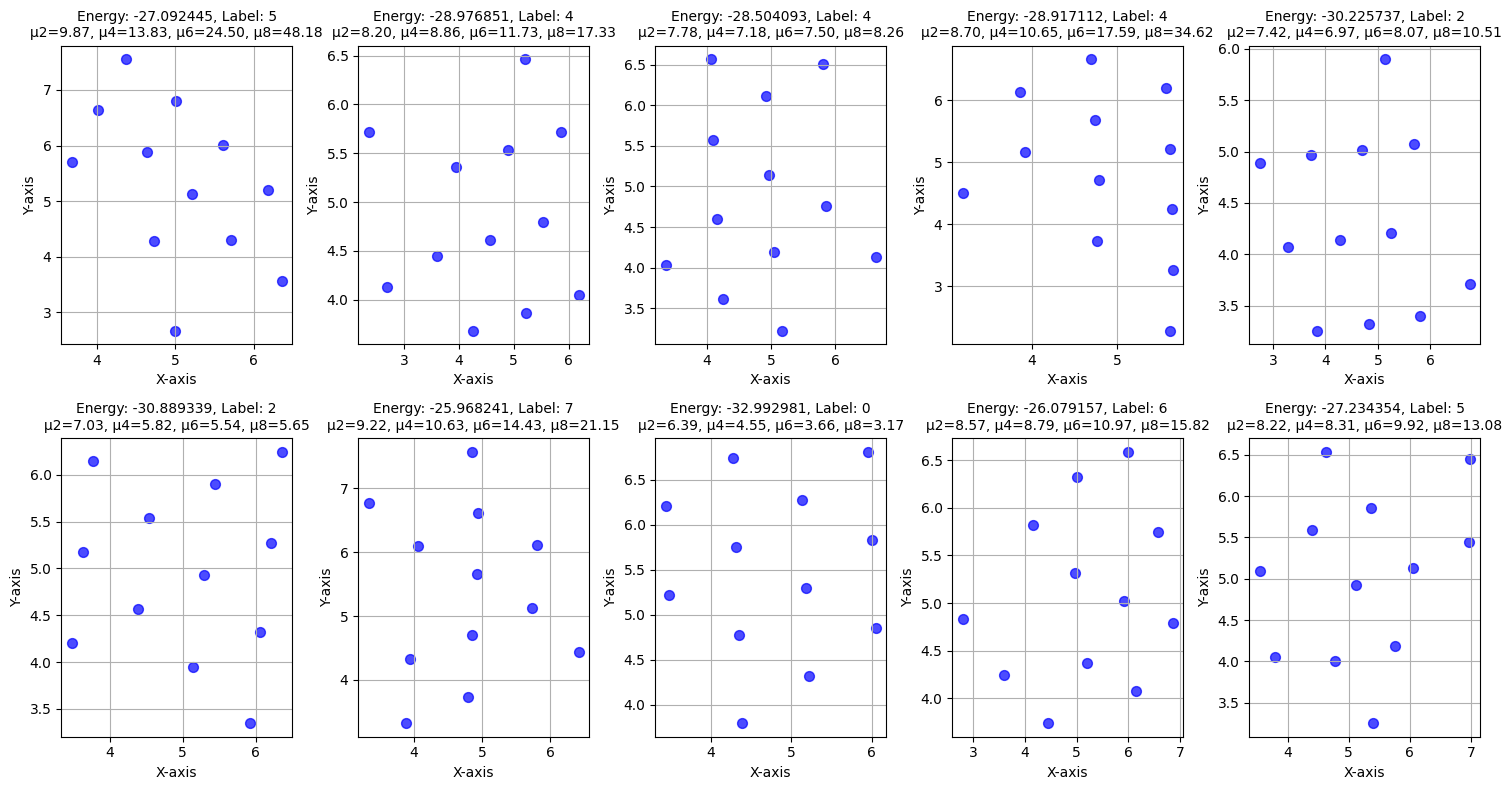

In [73]:
# Ensure positions is correctly shaped: (10, 12, 2)
positions = np.array(positions_from_file)

# Number of subplots
num_subplots = positions.shape[0]

# Set up subplots (2 rows, 5 columns for 10 subplots)
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Loop through each subplot
for i, ax in enumerate(axes):
    # Extract x and y coordinates for the current cluster
    cluster = positions[i]
    x_coords = cluster[:, 0]
    y_coords = cluster[:, 1]

    # Calculate the moments for the current cluster
    mu_2, mu_4, mu_6, mu_8 = moment_calculator(cluster)

    # Scatter plot for the current cluster
    ax.scatter(x_coords, y_coords, s=50, c='blue', alpha=0.7)

    # Add title and moments to the plot
    ax.set_title(
        f"Energy: {energies_from_file[i]}, Label: {labels_from_file[i]}\n"
        f"μ2={mu_2:.2f}, μ4={mu_4:.2f}, μ6={mu_6:.2f}, μ8={mu_8:.2f}",
        fontsize=10
    )
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.grid(True)

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()

d) Make an array with the 1000 4-dimensional descriptors, one for each cluster.



In [82]:
moment_descriptors = []
positions = np.array(positions_from_file)

for i in range(len(positions)):
    cluster = positions[i]
    mu_2, mu_4, mu_6, mu_8 = moment_calculator(cluster)
    moment_descriptors.append([mu_2,mu_4,mu_6,mu_8])

print(moment_descriptors[1])

[np.float64(8.202504608137973), np.float64(8.855431436160298), np.float64(11.731836295533663), np.float64(17.3260668001734)]


7.4 Split the data

Below, you will set up a neural network. The network will take the 4-dimensional descriptors as input and output 10 weights that via softmax will give the probabilities for the 10 labels, 0, 1 through 9. In order to train the network, you will need to have DataLoaders that handle the descriptors and the labels (but not the energies).

e) Split the data in 80-10-10 percentage fractions for use as training, validation, and test data, respectively. If you feel like it, plot the three sets as before (remember the energies will not be used by the network).

Define the Dataset

In [84]:
from torch.utils.data import DataLoader, Dataset, random_split

class DescriptorDataset(Dataset):
    def __init__(self, descriptors, labels):
        self.descriptors = descriptors
        self.labels = labels

    def __len__(self):
        return len(self.descriptors)

    def __getitem__(self, idx):
        return torch.tensor(self.descriptors[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)


Split Data into Training, Validation, and Test Sets

In [98]:
labels = labels_from_file

# Convert to NumPy arrays
moment_descriptors = np.array(moment_descriptors)
labels = np.array(labels)

# Dataset and split
dataset = DescriptorDataset(moment_descriptors, labels)
dataset_size = len(dataset)

train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Define the NN

In [99]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)


 Initialize Model, Loss Function, and Optimizer

In [100]:
# Initialize the model
input_dim = 4  # Number of dimensions in the descriptor
output_dim = 10  # Number of labels (0 to 9)
model = NeuralNet(input_dim, output_dim)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Training and Validation Loops

In [102]:
# Training loop
epochs = 200

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for descriptors_batch, labels_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(descriptors_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for descriptors_batch, labels_batch in val_loader:
            outputs = model(descriptors_batch)
            loss = criterion(outputs, labels_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


1000
1000
Epoch 1/200, Train Loss: 2.2237, Validation Loss: 2.2044
Epoch 2/200, Train Loss: 2.2226, Validation Loss: 2.1948
Epoch 3/200, Train Loss: 2.2249, Validation Loss: 2.2076
Epoch 4/200, Train Loss: 2.2249, Validation Loss: 2.1932
Epoch 5/200, Train Loss: 2.2185, Validation Loss: 2.2128
Epoch 6/200, Train Loss: 2.2219, Validation Loss: 2.1997
Epoch 7/200, Train Loss: 2.2195, Validation Loss: 2.2075
Epoch 8/200, Train Loss: 2.2216, Validation Loss: 2.2071
Epoch 9/200, Train Loss: 2.2299, Validation Loss: 2.2040
Epoch 10/200, Train Loss: 2.2199, Validation Loss: 2.2079
Epoch 11/200, Train Loss: 2.2185, Validation Loss: 2.1915
Epoch 12/200, Train Loss: 2.2211, Validation Loss: 2.1976
Epoch 13/200, Train Loss: 2.2201, Validation Loss: 2.2074
Epoch 14/200, Train Loss: 2.2198, Validation Loss: 2.1923
Epoch 15/200, Train Loss: 2.2162, Validation Loss: 2.1881
Epoch 16/200, Train Loss: 2.2177, Validation Loss: 2.2020
Epoch 17/200, Train Loss: 2.2162, Validation Loss: 2.1989
Epoch 18/200,

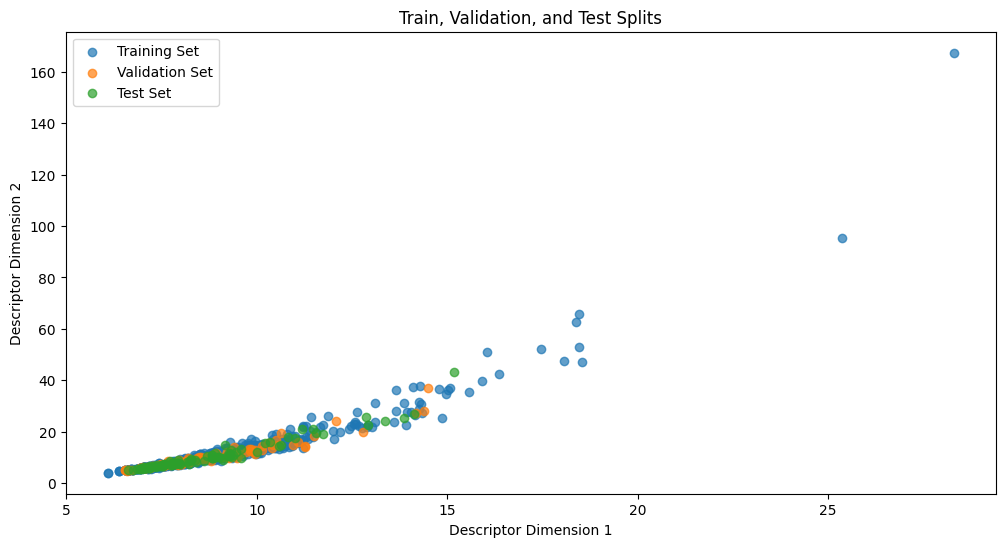

In [103]:
# Extract data for plotting
train_descriptors = np.array([dataset[i][0].numpy() for i in train_dataset.indices])
val_descriptors = np.array([dataset[i][0].numpy() for i in val_dataset.indices])
test_descriptors = np.array([dataset[i][0].numpy() for i in test_dataset.indices])

# Plot each set
plt.figure(figsize=(12, 6))
plt.scatter(train_descriptors[:, 0], train_descriptors[:, 1], label="Training Set", alpha=0.7)
plt.scatter(val_descriptors[:, 0], val_descriptors[:, 1], label="Validation Set", alpha=0.7)
plt.scatter(test_descriptors[:, 0], test_descriptors[:, 1], label="Test Set", alpha=0.7)
plt.legend()
plt.title("Train, Validation, and Test Splits")
plt.xlabel("Descriptor Dimension 1")
plt.ylabel("Descriptor Dimension 2")
plt.show()
